In [ ]:
#default_exp basics.interp

In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

# Showing prediction results for specific items (Beginner)

> Extending the `Interpretation` class with the `show_at` method

In [ ]:
#hide
from wwf.utils import *

In [ ]:
#hide_input
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai`: 2.1.10 
* `fastcore`: 1.3.16 
* `wwf`: 0.0.10 
---

## My problem

I often want to look at the predictions of specific items in the validation set, to see if I can find patterns in the errors made by the model. This notebook extends the `Interpretation` object created on top of a learner to add a shortcut method, `show_at` that does exactly this.  Let's use as example the "is a cat" classifier, as trained in the [fastbook](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb) 

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.236168,0.032297,0.009512,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.066912,0.011714,0.005945,00:24


Creating a `ClassificationInterpretation` from the learner will give us shorcuts to interpret its results. By default, the Intepretation object will be created around the validation dataloader

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Let's say we are interested in the predictions for the first item of the validation set. Normally, what I do to visualize both the item and predictions for a single item is to first show it in the dataset and then see its prediction in `interp.preds` or `interp.decoded`

tensor(0)


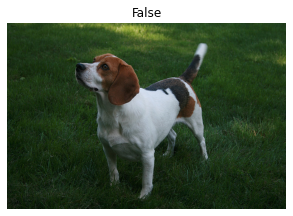

In [ ]:
item_idx = 0
show_at(dls.valid.dataset, item_idx)
print(interp.decoded[item_idx])

It would be much easier if we could just call `show_at` as a method of the `interp` object, and plot the results in the same way that `learn.show_results` does it. Here's a piece of code by Zach Mueller, taken from the discord community, to achieve this goal.

In [ ]:
#export
@patch
def __getitem__(self:Interpretation, idxs):
    "Get the inputs, preds, targets, decoded outputs, and losses at `idx`"
    if not is_listy(idxs): idxs = [idxs]
    attrs = 'inputs,preds,targs,decoded,losses'
    res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
    return res

@patch
def show_at(self:Interpretation, idx:int, **kwargs):
    inp, _, targ, dec, _ = self[idx]
    dec, targ = L(dec, targ).map(Self.unsqueeze(0))
    self.dl.show_results((inp, dec), targ, **kwargs)

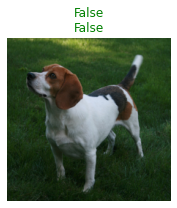

In [ ]:
interp.show_at(tensor(0))

Here's another example to show the predictions of the item in the validation set with the largest loss

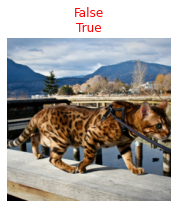

In [ ]:
interp.show_at(interp.top_losses(k=1).indices[0])

Additionaly, the method `__getitem__` is also very useful when you want to know everything (data, prediction, decoded prediction, actual label) of a specific item of the dataset.

In [ ]:
interp[0]

(#5) [TensorImage([[[[-1.0733, -1.1589, -1.2274,  ..., -1.5185, -1.4500, -1.4500],
          [-1.2103, -1.1247, -1.1932,  ..., -1.5014, -1.4500, -1.5014],
          [-1.2788, -1.1589, -1.2103,  ..., -1.5185, -1.4843, -1.5357],
          ...,
          [-1.8953, -1.7925, -1.8268,  ..., -1.6727, -1.7583, -1.8439],
          [-1.9295, -1.7754, -1.8268,  ..., -1.6555, -1.7412, -1.8610],
          [-1.8268, -1.7925, -1.8782,  ..., -1.7925, -1.7412, -1.6898]],

         [[-0.4951, -0.5651, -0.6702,  ..., -0.8627, -0.7927, -0.8277],
          [-0.5651, -0.4776, -0.6176,  ..., -0.7927, -0.7577, -0.7927],
          [-0.6176, -0.5126, -0.6352,  ..., -0.8277, -0.7927, -0.8627],
          ...,
          [-1.4930, -1.3179, -1.3529,  ..., -1.2479, -1.3880, -1.4580],
          [-1.5105, -1.2654, -1.3529,  ..., -1.2129, -1.3354, -1.4580],
          [-1.4405, -1.2829, -1.4405,  ..., -1.3354, -1.3354, -1.3179]],

         [[-1.0724, -1.1596, -1.2119,  ..., -1.2816, -1.2467, -1.2467],
          [-1.1944,